# D7059E

*   Jacob Yousif
*   Donato Scarano


## Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%capture
!pip install pytorch-tabnet matplotlib seaborn

In [3]:
%%capture
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import seaborn as sns
from itertools import cycle
from sklearn.metrics import multilabel_confusion_matrix

## Data Loading

In [4]:
file_path = 'datasets/Vectorized15SentenceSegments.csv'
df = pd.read_csv(file_path)
main = df.copy()

In [5]:
plots_dir = 'a/16/'

In [6]:
df = df.dropna().reset_index(drop=True)

In [7]:
df

,Book,Author,Genre,Publish-Year,Average-Rating,AuthorCode,AverageWordLength,AverageSentenceLengthByWord,AverageSyllablePerWord,SpecialCharactersCount,...,ShannonEntropy,FleschReadingEase,FleschKincaidGradeLevel,DaleChallReadability,GunningFog,AverageSentenceLengthByChar,Sentiment,Text,Pre-Text,Lemmatized-Text
0,Sense And Sensibility,Jane Austen,Romance,1811,4.08,0,6.315789,26.800000,1.968586,0.000439,...,4.156171,64.44,10.1,25.760267,12.13,151.000000,0.147207,CHAPTER I. The family of Dashwood had long bee...,chapter family dashwood long settled sussex es...,chapter family dashwood long settle sussex est...
1,Sense And Sensibility,Jane Austen,Romance,1811,4.08,0,6.294821,37.933333,1.940711,0.001916,...,4.115308,54.39,14.0,28.428606,16.07,207.800000,0.119557,"By his own marriage, likewise, which happened ...",marriage likewise happened soon afterwards add...,marriage likewise happen soon afterwards add w...
2,Sense And Sensibility,Jane Austen,Romance,1811,4.08,0,6.331492,24.733333,1.977901,0.004239,...,4.152497,68.60,8.5,25.257014,10.82,140.600000,0.124122,He survived his uncle no longer; and ten thous...,survived uncle longer ten thousand pounds incl...,survive uncle longer ten thousand pound includ...
3,Sense And Sensibility,Jane Austen,Romance,1811,4.08,0,6.470852,29.933333,2.048673,0.002263,...,4.172757,58.21,10.5,27.036251,12.30,175.800000,0.247345,"“Yes, he would give them three thousand pounds...",yes would give three thousand pounds would lib...,yes would give three thousand pound would libe...
4,Sense And Sensibility,Jane Austen,Romance,1811,4.08,0,6.735849,20.933333,2.194969,0.003071,...,4.204731,60.04,9.8,24.674952,12.17,129.333333,0.169444,"Marianne’s abilities were, in many respects, q...",mariannes abilities many respects quite equal ...,mariannes ability many respect quite equal eli...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28831,A Passage To India,E. M. Forster,Historical Fiction,1924,3.68,6,5.390909,25.533333,1.756757,0.004948,...,4.435174,65.56,9.7,25.385064,12.34,147.266667,-0.034190,"She, whose only peer was the Holy Roman Empire...",whose peer holy roman empire shall rank guatem...,whose peer holy roman empire shall rank guatem...
28832,A Passage To India,E. M. Forster,Historical Fiction,1924,3.68,6,6.363636,32.266667,2.112319,0.007749,...,4.361411,50.97,11.2,27.908210,13.04,196.933333,0.226107,E. M. FORSTERS NOVELS_ WHERE ANGELS FEAR TO TR...,e forsters novels angels fear tread remarkable...,e forsters novels angel fear tread remarkable ...
28833,A Passage To India,E. M. Forster,Historical Fiction,1924,3.68,6,6.160221,21.200000,2.011050,0.004191,...,4.283655,63.80,8.3,24.528854,11.01,126.333333,0.225593,The characters are as clear and salient as a p...,characters clear salient portrait sargent many...,character clear salient portrait sargent many ...
28834,A Passage To India,E. M. Forster,Historical Fiction,1924,3.68,6,5.562212,28.769231,1.844749,0.008174,...,4.317975,70.33,7.9,25.513404,10.76,168.461538,0.267317,"Had this element been there alone, the book wo...",element alone book would merely excellent sati...,element alone book would merely excellent sati...


In [8]:
print('The length of the dataset is:', str(len(df)))

The length of the dataset is: 28836


In [9]:
has_nan = df.isnull().values.any()
print(f"Are there any NaN values in the DataFrame? {has_nan}")

Are there any NaN values in the DataFrame? False


In [10]:
print(f"Does the DataFrame have any NaN values? {df.isna().sum().sum()}")

Does the DataFrame have any NaN values? 0


## Authors

In [11]:
authors = df.groupby('AuthorCode').agg(SegmentCount=('AuthorCode', 'size'), Author=('Author', 'first')).reset_index()

In [12]:
authors

,AuthorCode,SegmentCount,Author
0,0,1461,Jane Austen
1,1,576,L. Frank Baum
2,2,2014,Joseph Conrad
3,3,1928,Charles Dickens
4,4,2073,George Eliot
5,5,1624,Gustave Flaubert
6,6,1702,E. M. Forster
7,7,614,Kenneth Grahame
8,8,4854,Victor Hugo
9,9,1219,Jack London


### Pre-defined Setup

In [13]:
x_columns = [
    'AverageWordLength', 'AverageSentenceLengthByWord', 'AverageSyllablePerWord', 'SpecialCharactersCount',
    'PunctuationCount', 'FunctionalWordsCount', 'TypeTokenRatio', 'HonoreMeasureR',
    'Hapax', 'SichelesMeasureS', 'Dihapax', 'YulesCharacteristicK', 'SimpsonsIndex',
    'BrunetsMeasureW', 'ShannonEntropy', 'FleschReadingEase', 'FleschKincaidGradeLevel',
    'DaleChallReadability', 'GunningFog'
]
y_column = ['AuthorCode']

In [14]:
def write(file_name, latex_table):
    with open(file_name, 'w') as f:
        f.write(latex_table)

In [15]:
def to_pascal_case(s):
    return ''.join(word.capitalize() for word in s.split('_'))

### TabNet 

In [16]:
X = df[x_columns]
y = df[y_column]

In [17]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [18]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

In [19]:
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [21]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax')

In [22]:
clf.fit(
  X_train, y_train,
  eval_set=[(X_val, y_val)],
  eval_name=['test'],
  eval_metric=['accuracy', 'logloss'],
  max_epochs=100,
  patience=3,
  batch_size=256,
  virtual_batch_size=128,
  num_workers=0,
  drop_last=False
)

epoch 0  | loss: 2.49286 | test_accuracy: 0.26745 | test_logloss: 2.28155 |  0:00:02s
epoch 1  | loss: 2.11742 | test_accuracy: 0.33957 | test_logloss: 2.0439  |  0:00:05s
epoch 2  | loss: 1.99606 | test_accuracy: 0.36916 | test_logloss: 1.94148 |  0:00:08s
epoch 3  | loss: 1.91593 | test_accuracy: 0.38581 | test_logloss: 1.89223 |  0:00:10s
epoch 4  | loss: 1.85161 | test_accuracy: 0.40661 | test_logloss: 1.84216 |  0:00:13s
epoch 5  | loss: 1.79282 | test_accuracy: 0.43389 | test_logloss: 1.75787 |  0:00:15s
epoch 6  | loss: 1.76203 | test_accuracy: 0.44313 | test_logloss: 1.72578 |  0:00:17s
epoch 7  | loss: 1.7178  | test_accuracy: 0.43504 | test_logloss: 1.76137 |  0:00:20s
epoch 8  | loss: 1.71845 | test_accuracy: 0.45469 | test_logloss: 1.67369 |  0:00:22s
epoch 9  | loss: 1.67388 | test_accuracy: 0.46232 | test_logloss: 1.65711 |  0:00:24s
epoch 10 | loss: 1.64185 | test_accuracy: 0.46764 | test_logloss: 1.65436 |  0:00:26s
epoch 11 | loss: 1.63572 | test_accuracy: 0.45631 | te

In [23]:
y_pred = clf.predict(X_test)

In [24]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [25]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.49849710982658957
Precision: 0.5071670022512452
Recall: 0.49849710982658957
F1 Score: 0.4892995282332451


In [26]:
metrics_data = {'Accuracy': [accuracy], 'Precision': [precision], 'F1-Score': [f1], 'Recall': [recall]}

In [27]:
metrics_df = pd.DataFrame(metrics_data)

In [28]:
metrics_df

,Accuracy,Precision,F1-Score,Recall
0,0.498497,0.507167,0.4893,0.498497


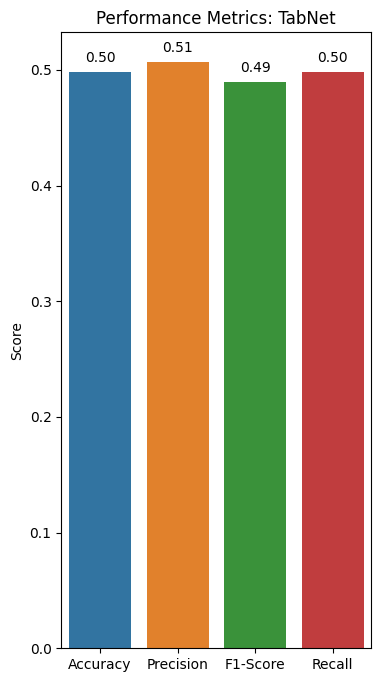

In [29]:
plt.figure(figsize=(4, 8))
ax = sns.barplot(data=metrics_df)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha = 'center',  
                va = 'center',  
                xytext = (0, 10),  
                textcoords = 'offset points')
plt.title('Performance Metrics: TabNet')
plt.ylabel('Score')
plt.savefig(f'{plots_dir}performance_TabNet_16.pdf', bbox_inches='tight')
plt.show()

In [30]:
y_prob = clf.predict_proba(X_test)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_prob.shape[1]

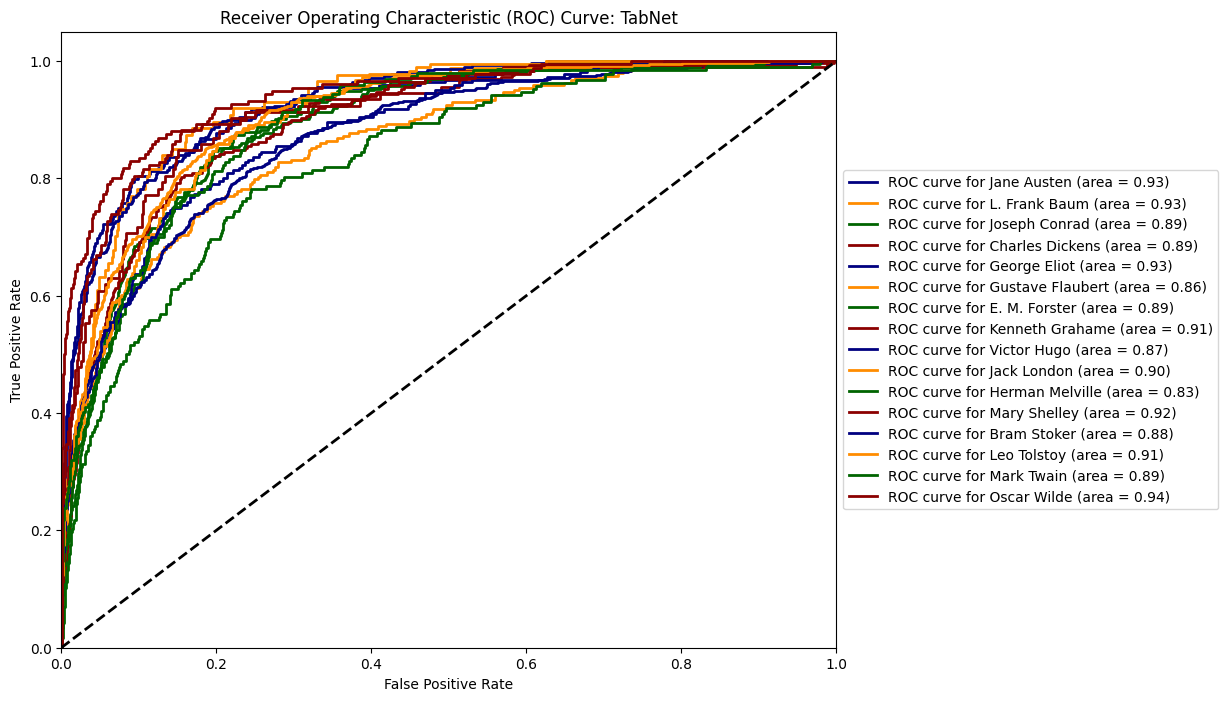

In [31]:
author_map = dict(zip(authors['AuthorCode'], authors['Author']))
n_classes = len(label_encoder.classes_)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['navy', 'darkorange', 'darkgreen', 'darkred'])

plt.figure(figsize=(10, 8))

for i, color in zip(range(n_classes), colors):
    label = author_map.get(i, f'Class {i}')
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {label} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve: TabNet')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'{plots_dir}roc__TabNet_16.pdf', bbox_inches='tight')
plt.show()

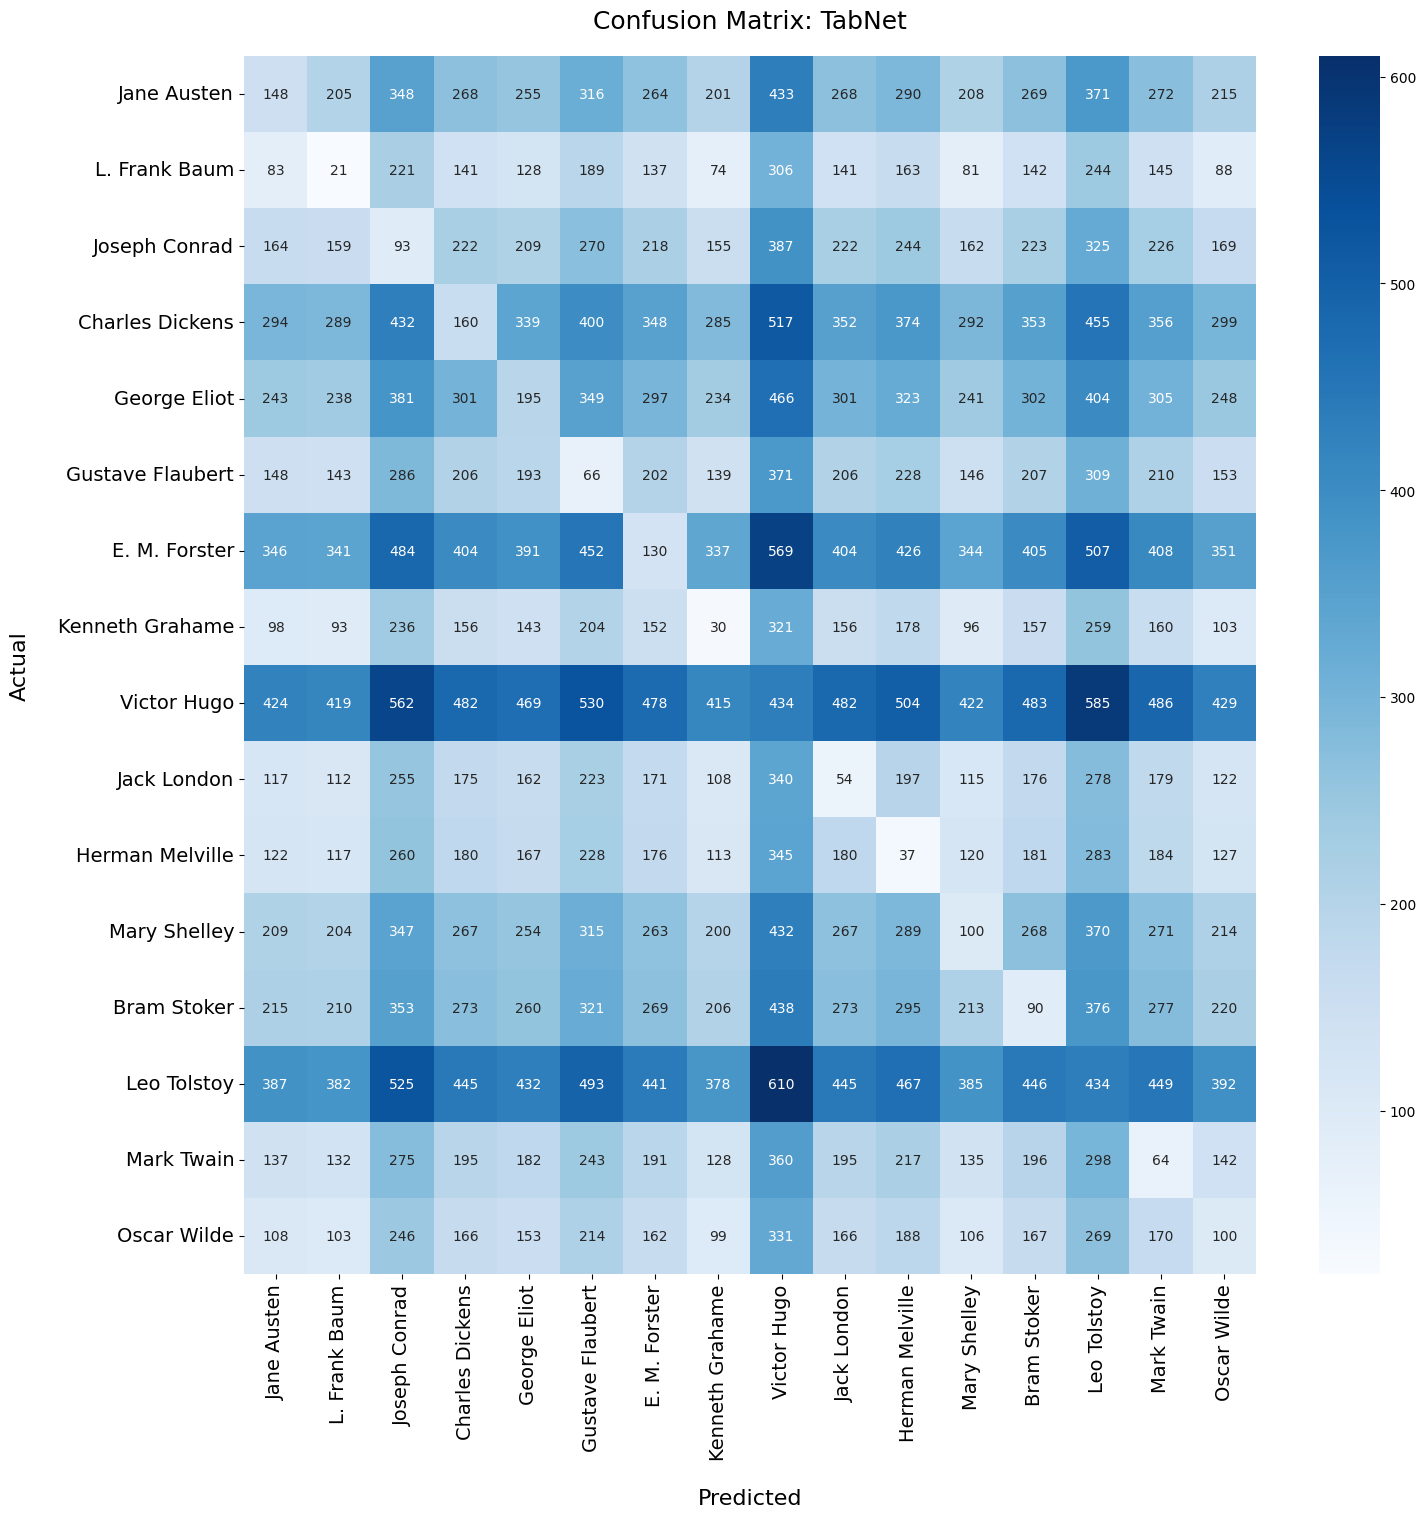

In [32]:
mcm = multilabel_confusion_matrix(y_test, y_pred)


total_labels = mcm.shape[0]
conf_matrix = np.zeros((total_labels, total_labels), dtype=int)

for label_index in range(total_labels):
    tn, fp, fn, tp = mcm[label_index].ravel()
    conf_matrix[label_index, label_index] = tp
    for i in range(total_labels):
        if i != label_index:

            fn_other, fp_other = mcm[i, 1, 0], mcm[i, 0, 1]
            conf_matrix[label_index, i] += fn_other
            conf_matrix[i, label_index] += fp_other


label_to_author = dict(zip(authors['AuthorCode'], authors['Author']))
author_names = [label_to_author.get(i, f'Label: {i}') for i in range(total_labels)]


plt.figure(figsize=(16, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=author_names, yticklabels=author_names)


plt.xlabel('Predicted', labelpad=20, fontsize=16)
plt.ylabel('Actual', labelpad=20, fontsize=16)
plt.title('Confusion Matrix: TabNet', pad=20, fontsize=18)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.tight_layout()
plt.subplots_adjust(left=0.2, bottom=0.2)  


plt.savefig(f'{plots_dir}cm_16_all2.pdf', bbox_inches='tight')
plt.show()

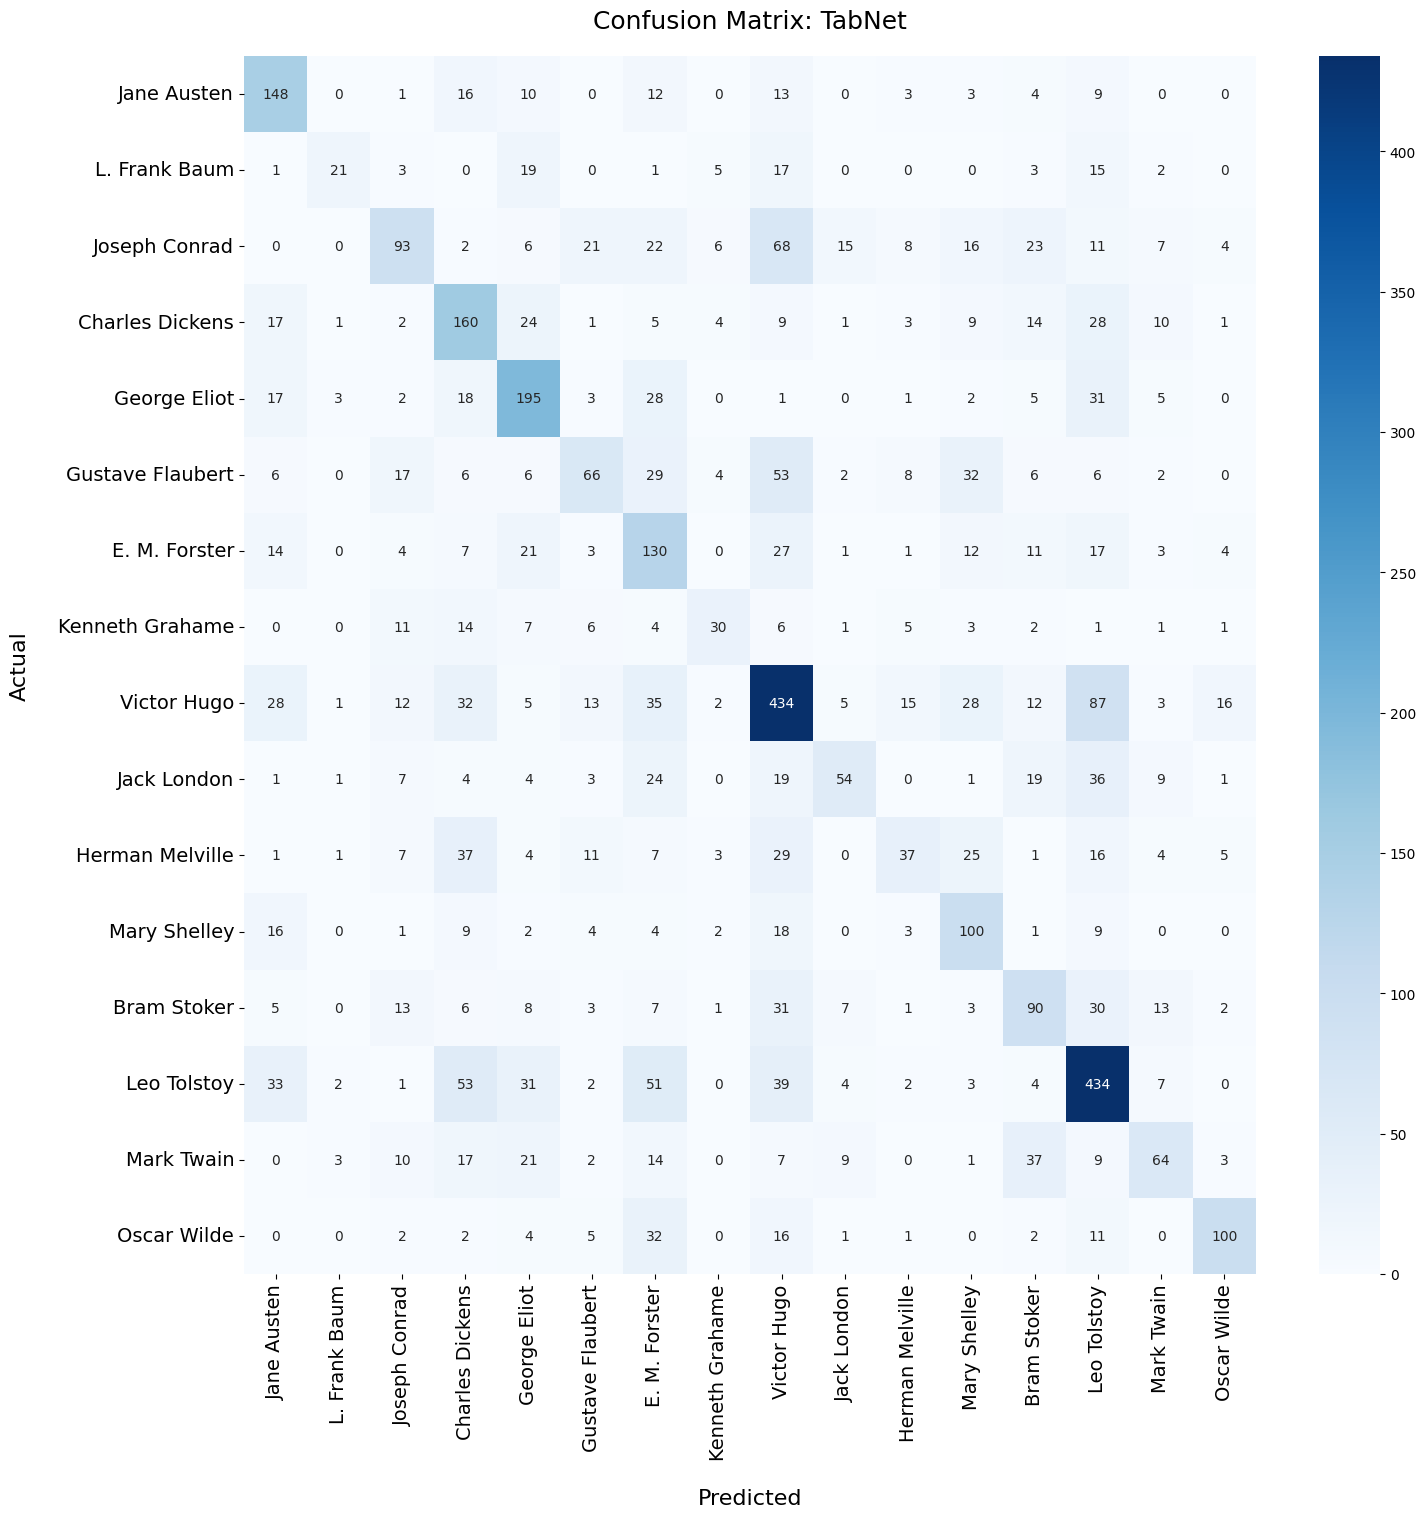

In [48]:
cm = confusion_matrix(y_test, y_pred)

# Author mappings
authors = {
    0: 'Jane Austen',
    1: 'L. Frank Baum',
    2: 'Joseph Conrad',
    3: 'Charles Dickens',
    4: 'George Eliot',
    5: 'Gustave Flaubert',
    6: 'E. M. Forster',
    7: 'Kenneth Grahame',
    8: 'Victor Hugo',
    9: 'Jack London',
    10: 'Herman Melville',
    11: 'Mary Shelley',
    12: 'Bram Stoker',
    13: 'Leo Tolstoy',
    14: 'Mark Twain',
    15: 'Oscar Wilde'
}

# Extract author names in the order of their codes
author_names = [authors.get(i, f'Label: {i}') for i in range(len(authors))]

plt.figure(figsize=(16, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=author_names, yticklabels=author_names)

plt.xlabel('Predicted', labelpad=20, fontsize=16)
plt.ylabel('Actual', labelpad=20, fontsize=16)
plt.title('Confusion Matrix: TabNet', pad=20, fontsize=18)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.tight_layout()
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.savefig(f'{plots_dir}cm_16_all2.pdf', bbox_inches='tight')
plt.show()

In [33]:
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Precision: ', precision)

Accuracy: 0.49849710982658957
Recall: 0.49849710982658957
F1 Score: 0.4892995282332451
Precision:  0.5071670022512452


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [35]:
epochs = list(range(13))

losses = [2.4416, 2.10448, 1.92807, 1.81999, 1.74711, 1.71424, 1.69356, 1.67537, 1.65719, 1.6369, 1.62002, 1.61855, 1.61218]

test_accuracies = [0.25572, 0.3509, 0.40482, 0.43395, 0.43603, 0.44816, 0.457, 0.44452, 0.45336, 0.47798, 0.46151, 0.46533, 0.46359]

best_epoch = 9
best_test_accuracy = 0.47798

In [36]:
results_df = pd.DataFrame({'Epoch': epochs, 'Loss': losses, 'Test Accuracy': test_accuracies})

In [39]:
epochs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

 = [2.49286, 2.11742, 1.99606, 1.91593, 1.85161, 1.79282, 1.76203, 1.7178, 1.71845, 1.67388, 1.64185, 1.63572, 1.62201, 1.60345, 1.58713, 1.57303, 1.5682, 1.56124, 1.54938]

test_accuracy = [0.26745, 0.33957, 0.36916, 0.38581, 0.40661, 0.43389, 0.44313, 0.43504, 0.45469, 0.46232, 0.46764, 0.45631, 0.47434, 0.47087, 0.47064, 0.49098, 0.4577, 0.46394, 0.4614]

test_logloss = [2.28155, 2.0439, 1.94148, 1.89223, 1.84216, 1.75787, 1.72578, 1.76137, 1.67369, 1.65711, 1.65436, 1.68787, 1.61932, 1.61935, 1.62893, 1.59647, 1.65755, 1.63752, 1.65079]


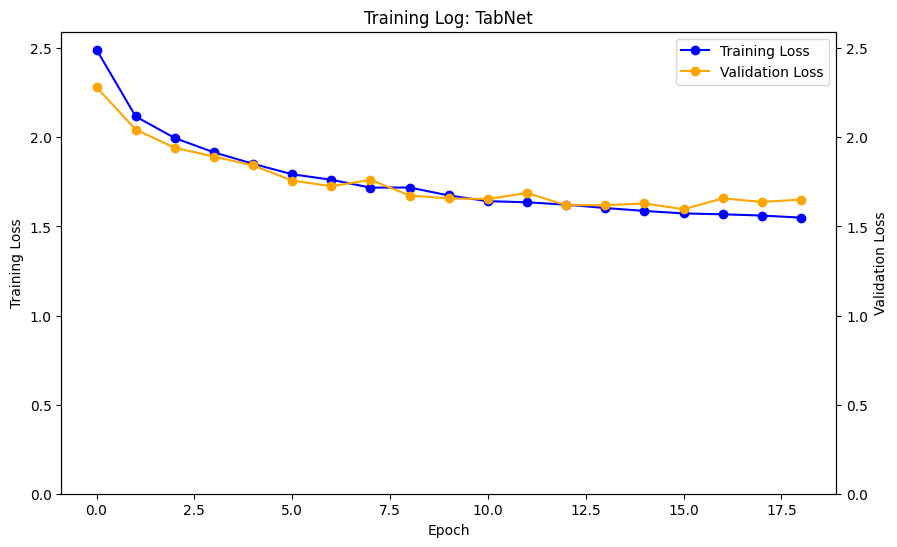

In [43]:
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax1.plot(epochs, loss, label='Training Loss', marker='o', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(epochs, test_logloss, label='Validation Loss', marker='o', color='orange')
ax2.set_ylabel('Validation Loss')

# Set the same scale for both y-axes, starting from 0
common_max = max(max(loss), max(test_logloss))
ax1.set_ylim(0, common_max+ 0.1)
ax2.set_ylim(0, common_max+ 0.1)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

plt.title('Training Log: TabNet')
plt.savefig('log_tab_16.pdf', bbox_inches='tight')

plt.show()

In [ ]:
len(X_val)